In [ ]:
!pip install unrar
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
!unrar x "/content/Alzheimer_s Dataset.rar" "/content/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg      20%  OK 
Extracting  /content/Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg      20%  OK 
Extracting  /content/Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg      20%  OK 
Extracting  /content/Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg      20%  OK 
Extracting  /content/Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg      20%  OK 
Extracting  /content/Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg      20%  OK 
Extracting  /content/Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg      20%  OK 
Extracting  /content/Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg      20%  OK 
Extracting  /content/Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg      20%  OK 
Extracting  /content/Alzheimer_s Dataset/train/MildDemented/mildDem

# 1. Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os

In [ ]:
# directory of dataset
dataset_dir = "/content/Alzheimer_s Dataset/"
train_dir = dataset_dir + 'train/'
test_dir = dataset_dir + 'test/'
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

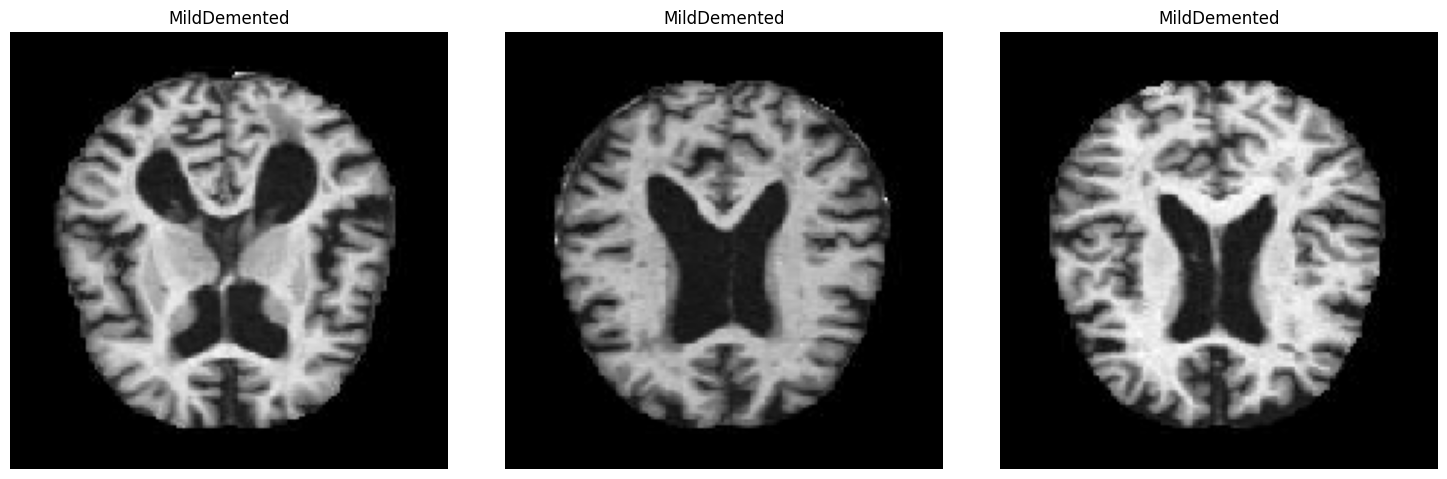

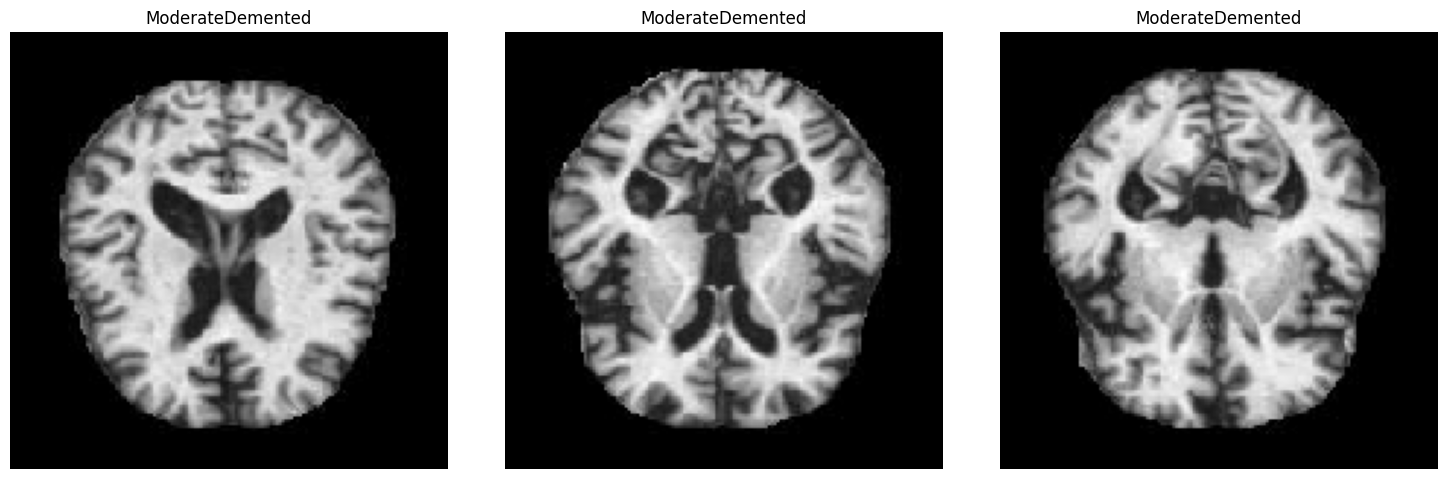

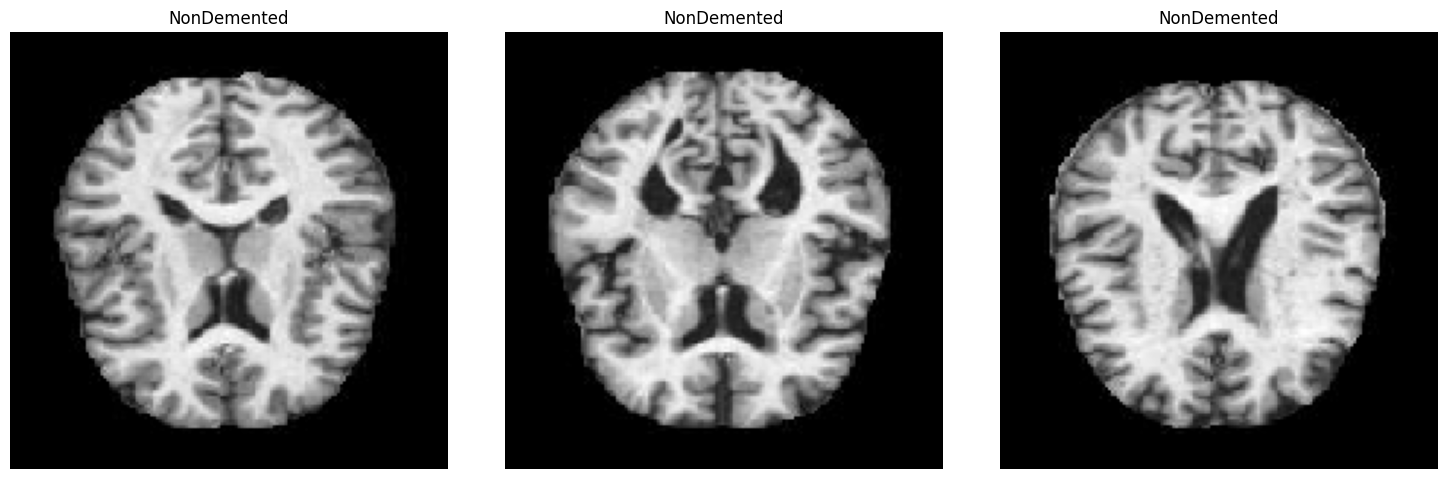

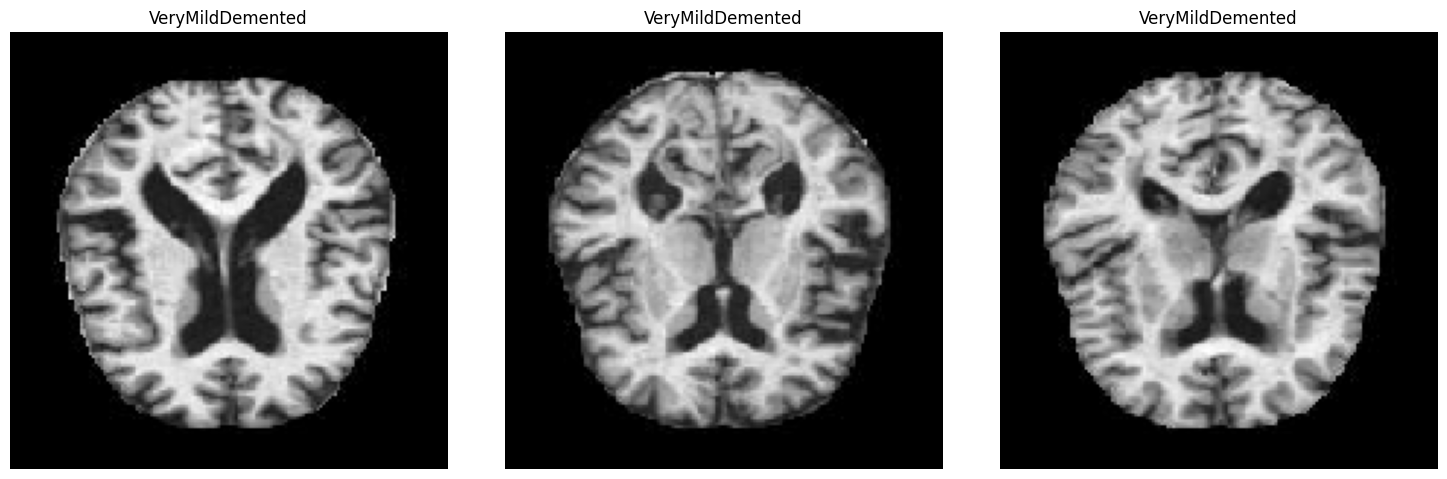

In [ ]:
def show_images(class_name):
    '''Function to explore images in each class'''
    fig, ax = plt.subplots(1, 3, figsize=(15,10))
    ax = ax.ravel()
    plt.tight_layout()

    for i, img in enumerate(os.listdir(os.path.join(train_dir, class_name))[:3]):
        img = image.load_img(os.path.join(train_dir, class_name, img),target_size=(150,150))
        ax[i].imshow(img)
        ax[i].set_title(class_name)
        ax[i].axis('off')

# plotting 3 images from each class to observe visual differences if any
for class_name in classes:
    show_images(class_name)

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                   color_mode='grayscale',
                                                   image_size=(150, 150),
                                                   shuffle=True,
                                                   seed=42)

Found 5121 files belonging to 4 classes.


In [ ]:
import numpy as np
labels = np.concatenate([y for x,y in data], axis=0)
import pandas as pd
values = pd.value_counts(labels)
values = values.sort_index()
class_names = data.class_names
for idx, name in enumerate(class_names):
    print(f"{idx} = {name}")

0 = MildDemented
1 = ModerateDemented
2 = NonDemented
3 = VeryMildDemented


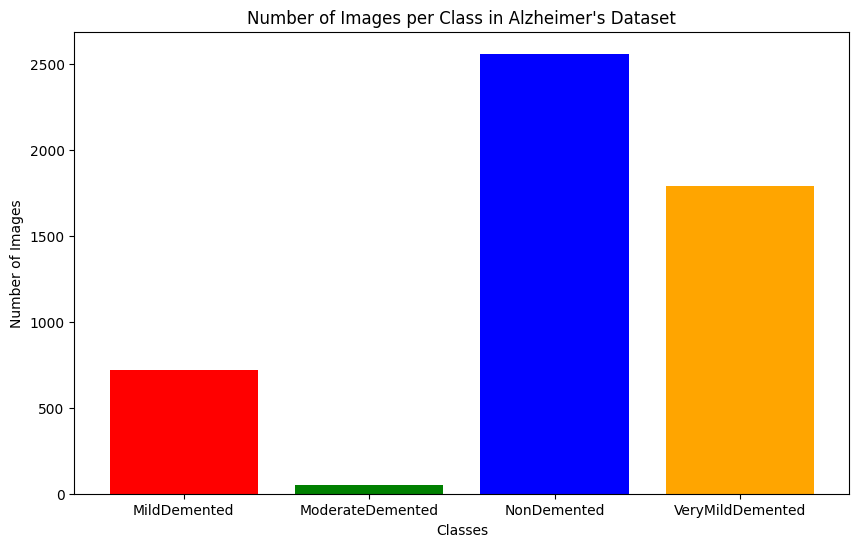

In [ ]:
# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_names, values, color=['red', 'green', 'blue', 'orange'])
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Alzheimer\'s Dataset')
plt.show()

There is a class imbalance. The NonDemented class has the highest number of images (2560), while ModerateDemented has the least (52). This imbalance can affect the performance of machine learning models, as they may become biased towards the classes with more data.

# 2. Data Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

train_datagen = ImageDataGenerator(
    rescale=1./255, # normalizing the dataset
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# as there is huge imbalance, there is a big requirement for validation dataset to hypertune the params

val_dir = dataset_dir + 'val/'

# Create new directories for validation set
if not os.path.exists(val_dir):
    os.mkdir(val_dir)
    for class_name in classes:
        os.mkdir(os.path.join(val_dir, class_name))

In [ ]:
import numpy as np
import shutil

split_ratio = 0.1  # 10% of the data will be moved to the validation set

for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    images = os.listdir(class_dir)
    np.random.shuffle(images)  # Shuffle the images to ensure random splitting

    # Calculate the split index
    split_index = int(len(images) * split_ratio)

    # Images to be moved to the validation set
    val_images = images[:split_index]

    # Move the images
    for image in val_images:
        src_path = os.path.join(class_dir, image)
        dest_path = os.path.join(val_dir, class_name, image)
        shutil.move(src_path, dest_path)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 4610 images belonging to 4 classes.
Found 511 images belonging to 4 classes.


In [ ]:
# calculate class weights

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes = np.unique(train_generator.classes),
    y = train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.7840557275541795,
 1: 24.52127659574468,
 2: 0.5002170138888888,
 3: 0.7145071295722256}

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall

# 3. Model Selection and Training

<h3> a) Transfer Learning Model

In [ ]:
# Load the model pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model
base_model.trainable = False

# Create a new model on top
transfer_model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(4, activation='softmax')
    ])

transfer_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='accuracy', patience=5, mode='max')

hist = transfer_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/15
145/145 [==============================] - 56s 284ms/step - loss: 1.0617 - accuracy: 0.5503 - val_loss: 1.2118 - val_accuracy: 0.4755
Epoch 2/15
145/145 [==============================] - 38s 261ms/step - loss: 0.8284 - accuracy: 0.6226 - val_loss: 1.0173 - val_accuracy: 0.5558
Epoch 3/15
145/145 [==============================] - 39s 268ms/step - loss: 0.8035 - accuracy: 0.6295 - val_loss: 0.9770 - val_accuracy: 0.5851
Epoch 4/15
145/145 [==============================] - 39s 266ms/step - loss: 0.7768 - accuracy: 0.6401 - val_loss: 0.9111 - val_accuracy: 0.5812
Epoch 5/15
145/145 [==============================] - 41s 283ms/step - loss: 0.7575 - accuracy: 0.6521 - val_loss: 1.0211 - val_accuracy: 0.5401
Epoch 6/15
145/145 [==============================] - 38s 265ms/step - loss: 0.7344 - accuracy: 0.6685 - val_loss: 0.9504 - val_accuracy: 0.5479
Epoch 7/15
145/145 [==============================] - 37s 256ms/step - loss: 0.7191 - accuracy: 0.6751 - val_loss: 1.2908 - val_ac

<h3> b) Custom Deep Neural Network (DNN)

Specifically for this dataset, the main focus is to keep in consideration of the imbalanced dataset.
Class weights will be considered while training the model.

In [ ]:
import keras_tuner as kt

def build_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(
            units=hp.Int('units', min_value=32, max_value=512, step=32),
            activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        layers.BatchNormalization(),
        layers.Dense(4, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float(
                'learning_rate',
                min_value=1e-4,
                max_value=1e-2,
                sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    directory='my_dir',
    project_name='alzheimer_classification',
    max_trials=10)

tuner.search(train_generator, validation_data=val_generator, epochs=10, class_weight=class_weights_dict)

Trial 10 Complete [00h 07m 24s]
val_accuracy: 0.5283757448196411

Best val_accuracy So Far: 0.6027397513389587
Total elapsed time: 01h 09m 49s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]


<h3> c) Student-Designed Model

In [ ]:
student_model = Sequential([
    Conv2D(64, (3,3),  activation="relu", input_shape=(150,150,3)),
    Conv2D(64, (3,3),  activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3),  activation="relu"),
    Conv2D(128, (3,3),  activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3),  activation="relu"),
    Conv2D(256, (3,3),  activation="relu"),
    Conv2D(256, (3,3),  activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    # Dropout(0.3),
    BatchNormalization(),
    Dense(4, activation="softmax")
])

<h4>Model Justification</h4>
<ol>
<li>Depth and Complexity for Feature Extraction:
The model uses a series of convolutional layers, starting with 64 filters and increasing up to 256 filters in deeper layers. This structure is designed to capture a wide range of features from the input images, starting from basic patterns in the initial layers to more complex features in the deeper layers. Such depth and complexity are crucial for dealing with the intricate patterns present in medical images like MRI scans, where subtle features might indicate different stages of Alzheimer's disease.

<li>
Use of ReLU Activation Function:
The ReLU (Rectified Linear Unit) activation function is used throughout the model. This choice is justified by ReLU's ability to introduce non-linearity without significantly impacting computational efficiency. ReLU helps the model in learning nonlinear features, which is essential for complex tasks like image classification, and it mitigates the vanishing gradient problem, common in deep networks.
<li>
Incorporation of Batch Normalization:
Batch normalization layers are included after each convolutional layer and before the activation function. These layers normalize the inputs to the next layer, reducing internal covariate shift which helps in stabilizing and speeding up the training process. By ensuring that each layer receives inputs with a standard distribution, batch normalization makes the model less sensitive to different weight initialization and learning rate choices.
<br>
<li>

Balanced Architecture with Pooling and Dense Layers:
The model uses MaxPooling layers to reduce the spatial dimensions, thereby decreasing the number of parameters and computational complexity. This approach not only helps in extracting dominant features but also combats overfitting. Following the convolutional and pooling layers, the model uses fully connected (Dense) layers to map the extracted features to the final classification. The gradual decrease in the number of neurons in these layers (512 to 128) before the final output layer is a strategic choice, enabling the model to effectively compress and interpret the feature information for classification.

</ol>

In [ ]:
student_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
student_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 conv2d_52 (Conv2D)          (None, 146, 146, 64)      36928     
                                                                 
 batch_normalization_33 (Ba  (None, 146, 146, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 73, 73, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 71, 71, 128)       73856     
                                                                 
 conv2d_54 (Conv2D)          (None, 69, 69, 128)      

In [ ]:
history = student_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/15
145/145 [==============================] - 57s 360ms/step - loss: 1.2217 - accuracy: 0.4649 - val_loss: 1.3524 - val_accuracy: 0.3875
Epoch 2/15
145/145 [==============================] - 45s 313ms/step - loss: 0.9787 - accuracy: 0.5284 - val_loss: 1.0967 - val_accuracy: 0.4501
Epoch 3/15
145/145 [==============================] - 45s 307ms/step - loss: 0.9531 - accuracy: 0.5341 - val_loss: 1.0008 - val_accuracy: 0.5049
Epoch 4/15
145/145 [==============================] - 51s 349ms/step - loss: 0.9321 - accuracy: 0.5354 - val_loss: 1.1042 - val_accuracy: 0.3894
Epoch 5/15
145/145 [==============================] - 53s 362ms/step - loss: 0.9315 - accuracy: 0.5354 - val_loss: 5.6853 - val_accuracy: 0.5029
Epoch 6/15
145/145 [==============================] - 55s 377ms/step - loss: 0.9265 - accuracy: 0.5482 - val_loss: 2.0445 - val_accuracy: 0.3503
Epoch 7/15
145/145 [==============================] - 53s 368ms/step - loss: 0.9301 - accuracy: 0.5594 - val_loss: 1.2373 - val_ac

# 4. Evaluation

In [ ]:
### a) Evaluation Transfer Learning Model

test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_loss, test_accuracy = transfer_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
y_pred = transfer_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Confusion matrix
print(confusion_matrix(y_true, y_pred_classes))

Found 1279 images belonging to 4 classes.
40/40 [==============================] - 11s 265ms/step - loss: 1.3181 - accuracy: 0.5543
Test Loss: 1.318078637123108, Test Accuracy: 0.5543393492698669
40/40 [==============================] - 14s 358ms/step
                  precision    recall  f1-score   support

    MildDemented       0.05      0.01      0.01       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.50      0.83      0.62       640
VeryMildDemented       0.36      0.11      0.17       448

        accuracy                           0.46      1279
       macro avg       0.23      0.24      0.20      1279
    weighted avg       0.38      0.46      0.37      1279

[[  1   6 158  14]
 [  0   0   9   3]
 [ 12  26 533  69]
 [  8  19 372  49]]


In [ ]:
### b) Evaluation DNN Model

test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Confusion matrix
print(confusion_matrix(y_true, y_pred_classes))

Found 1279 images belonging to 4 classes.
40/40 [==============================] - 10s 257ms/step - loss: 0.9053 - accuracy: 0.5973
Test Loss: 0.9053288698196411, Test Accuracy: 0.5973416566848755
40/40 [==============================] - 9s 235ms/step
                  precision    recall  f1-score   support

    MildDemented       0.10      0.06      0.08       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.50      0.60      0.55       640
VeryMildDemented       0.36      0.31      0.33       448

        accuracy                           0.42      1279
       macro avg       0.24      0.24      0.24      1279
    weighted avg       0.39      0.42      0.40      1279

[[ 11   1 109  58]
 [  2   0   6   4]
 [ 58  10 387 185]
 [ 35   5 269 139]]


In [ ]:
### c) Evaluation Student CNN Model

test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_loss, test_accuracy = student_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
y_pred = student_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Confusion matrix
print(confusion_matrix(y_true, y_pred_classes))

Found 1279 images belonging to 4 classes.
40/40 [==============================] - 10s 246ms/step - loss: 1.0469 - accuracy: 0.5270
Test Loss: 1.0468605756759644, Test Accuracy: 0.5269742012023926
40/40 [==============================] - 8s 196ms/step
                  precision    recall  f1-score   support

    MildDemented       0.10      0.01      0.01       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.49      0.74      0.59       640
VeryMildDemented       0.32      0.22      0.26       448

        accuracy                           0.45      1279
       macro avg       0.23      0.24      0.22      1279
    weighted avg       0.37      0.45      0.39      1279

[[  1   0 138  40]
 [  0   0   5   7]
 [  5   0 474 161]
 [  4   0 344 100]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 5. Discussion and Conclusion

<li> Dataset had a lot of imbalance which had an immensive impact on the training of data.
<li>The first model is trained using VGG16, and using weights from imagenet. The model produces a val_acc of 46%, but the confusion matrix shows that the model is not working good at all in 2 underpresented diseases.
<li> The second model is tuned using a keras tuner to find the optimal hyperparameters with RandomSearch method and produces an accuracy less than the previous model which is 42%. But can be seen in confusion matrix that it produces comparitively better results for even the underpresented diseases.
<li> The third model is created simple to reduce the computational time and cost and hence took the least amount of time to train. The model got a similar result of VGG16 despite having half the layers but along with multiple batchNormalization layers and also a similar confusion matrix.

A better model could have been made if the data was balanced at least to a factor of 5, but the cost imbalance as seen is way too much especially for ModerateDimentia having 26 times lesser data. And hence no model was able to create any precision in that class. The best model among these was the second one as it classified one of the underpresented class which can be seen in the confusion matrix generated.